# subsub
## 06 Batch reduce everything!!
### part I- Generate per-order HDF5 files needed for chunking, also trim off the order ends.

Michael Gully-Santiago and Natalie Gosnell at Houndstooth in Austin, TX!!
Thursday, June 8, 2017

Let's do it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
from astropy.io import fits
import h5py

## H-Band

- 64 is the target
- 72 is the A0V standard

In [3]:
hdu_raw = fits.open('../data/raw/SDCH_20150425_0064.spec_a0v.fits')
hdu_f   = fits.open('../data/raw/SDCH_20150425_0064.spec_a0v.fits')
hdu_var = fits.open('../data/raw/SDCH_20150425_0072.variance.fits')
hdu_tar = fits.open('../data/raw/SDCH_20150425_0064.spec_a0v.fits')
tar_var = fits.open('../data/raw/SDCH_20150425_0064.variance.fits')
hdr = hdu_tar[0].header

In [4]:
hdu_tar.info()

Filename: ../data/raw/SDCH_20150425_0064.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     183   (2048, 28)   float64   
  1  WAVELENGTH    1 ImageHDU       184   (2048, 28)   float64   
  2  TGT_SPEC      1 ImageHDU       184   (2048, 28)   float32   
  3  A0V_SPEC      1 ImageHDU       184   (2048, 28)   float32   
  4  VEGA_SPEC     1 ImageHDU       184   (2048, 28)   float64   


What are the entries in hdu_tar??


| index | interpretation |
|--|--|
|0 | Telluric corrected target spectrum|
|1 | Wavelength in micron|
|2 | Raw 1D spectrum of target|
|3 | Assumed telluric absorption?|
|4 | ??|

In [6]:
#plt.plot(pix, hdu_tar[4].data[o,:])

(0, 0.43387766879655659)

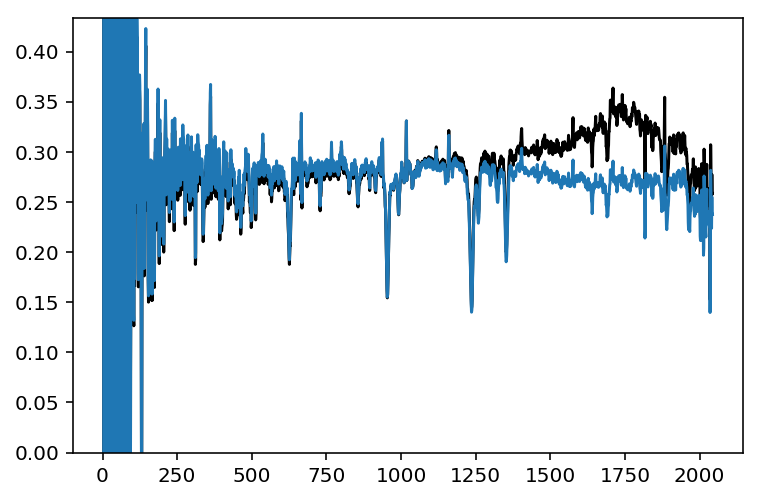

In [7]:
o=9
wls_out = hdu_tar[1].data[o,:]*10000.0
fls_out = hdu_tar[2].data[o,:]/hdu_tar[3].data[o,:]
fls_out2 = hdu_tar[0].data[o,:]

scl = np.nanmedian(fls_out2/fls_out)

pix = np.arange(2048)
plt.plot(pix, fls_out, 'k-')
plt.plot(pix, fls_out2/scl)
plt.ylim(0, 1.5*np.nanpercentile(fls_out2/scl, 85))

### Do the telluric correction
$ f_{\star} = \frac{f_{raw, \star}}{f_{raw, std}} \times \hat{f}_{std}$

$ \sigma_{\star} = f_{\star} \sqrt{ \left( \frac{\sigma_{raw, std}}{f_{raw, std}}\right)^2 + \left( \frac{\sigma_{raw, \star}}{f_{raw,\star}} \right)^2 } \times \hat{f}_{std}$

In [8]:
f_hat_std = hdu_f[4].data/np.nanmean(hdu_f[4].data)
f_star = hdu_tar[0].data/hdu_raw[0].data*f_hat_std
term1 = hdu_var[0].data / hdu_raw[0].data**2
term2 = tar_var[0].data / hdu_tar[0].data**2
sig_star = f_star * np.sqrt( term1 + term2 )*f_hat_std

## Plot it

We will trim between pixel 450 and 1950.

(0.0, 1.2)

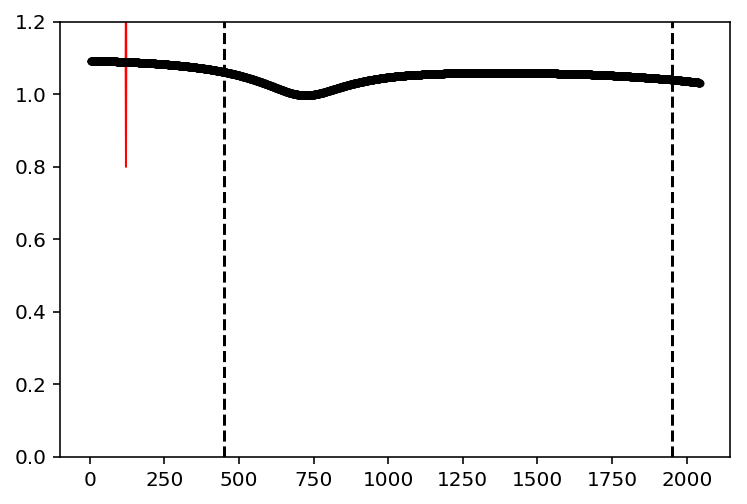

In [9]:
o=16
fls_out = f_star[o,:]
sig_out = sig_star[o,:]
wls_out = hdu_tar[1].data[o,:]*10000.0
sig = sig_out

pix = np.arange(2048)
plt.plot(pix, fls_out, 'k.')

plt.fill_between(pix, fls_out-sig, fls_out+sig, color='r')

plt.vlines(450, 0, 2, linestyles='--')
plt.vlines(1950, 0, 2, linestyles='--')
plt.ylim(0.0, 1.2)

In [14]:
bad_ids = (sig_out < 0) | (sig_out != sig_out) | (fls_out != fls_out) 

/Users/obsidian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [18]:
good_ids = ~bad_ids

In [11]:
lft = 450
rgt = 1950

for o in range(28):
    m = o + 98
    out_name = '../data/reduced/subsub_IGRINS_m{:03d}.hdf5'.format(m)
    fls_out = f_star[o,lft:rgt]
    sig_out = sig_star[o,lft:rgt]
    wls_out = hdu_tar[1].data[o,lft:rgt]*10000.0
    msk_out = np.ones(len(wls_out), dtype=int)
    f_new = h5py.File(out_name, 'w')
    f_new.create_dataset('fls', data=fls_out[good_ids])
    f_new.create_dataset('wls', data=wls_out[good_ids])
    f_new.create_dataset('sigmas', data=sig_out[good_ids])
    f_new.create_dataset('masks', data=msk_out[good_ids])
    print("{:03d}: {:.0f}  -  {:.0f}   {}".format(m, wls_out[0], wls_out[-1], out_name))
    f_new.close()

098: 18154  -  18336   ../data/reduced/subsub_IGRINS_m098.hdf5
099: 17975  -  18155   ../data/reduced/subsub_IGRINS_m099.hdf5
100: 17800  -  17978   ../data/reduced/subsub_IGRINS_m100.hdf5
101: 17628  -  17805   ../data/reduced/subsub_IGRINS_m101.hdf5
102: 17460  -  17635   ../data/reduced/subsub_IGRINS_m102.hdf5
103: 17295  -  17468   ../data/reduced/subsub_IGRINS_m103.hdf5
104: 17133  -  17305   ../data/reduced/subsub_IGRINS_m104.hdf5
105: 16975  -  17145   ../data/reduced/subsub_IGRINS_m105.hdf5
106: 16819  -  16988   ../data/reduced/subsub_IGRINS_m106.hdf5
107: 16667  -  16834   ../data/reduced/subsub_IGRINS_m107.hdf5
108: 16517  -  16682   ../data/reduced/subsub_IGRINS_m108.hdf5
109: 16370  -  16534   ../data/reduced/subsub_IGRINS_m109.hdf5
110: 16226  -  16388   ../data/reduced/subsub_IGRINS_m110.hdf5
111: 16084  -  16245   ../data/reduced/subsub_IGRINS_m111.hdf5
112: 15945  -  16105   ../data/reduced/subsub_IGRINS_m112.hdf5
113: 15809  -  15967   ../data/reduced/subsub_IGRINS_m1

## K-band

Skipping K-band because it's low signal-to-noise!

### The end!